In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [4]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [5]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [6]:
uber_man.tail()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday_N,hday_Y
pickup_dt,,,,,,,,,,,,
2015-06-30 19:00:00,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,1,0
2015-06-30 20:00:00,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,1,0
2015-06-30 21:00:00,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,1,0
2015-06-30 22:00:00,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,1,0
2015-06-30 23:00:00,3828,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,1,0


Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [7]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [10]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_perso(y_test,y_predict)

12.489389638804065

In [27]:
import lightgbm as lgb

In [28]:
uber_man.head()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday_N,hday_Y,lag_1,lag_2,lag_3,lag_4,lag_24,lag_168
pickup_dt,,,,,,,,,,,,,,,,,,
2015-01-08 01:00:00,739,21.0,10.0,12.0,-13.0,1022.7,0.0,0.0,0.0,0.833333,1,0,1524.0,2664.0,3603.0,3867.0,601.0,5258.0
2015-01-08 02:00:00,443,14.0,10.0,11.0,-11.0,1023.6,0.0,0.0,0.0,0.875000,1,0,739.0,1524.0,2664.0,3603.0,320.0,4345.0
2015-01-08 03:00:00,268,14.0,10.0,10.0,-11.0,1024.2,0.0,0.0,0.0,0.916667,1,0,443.0,739.0,1524.0,2664.0,204.0,4577.0
2015-01-08 04:00:00,217,13.0,10.0,10.0,-11.0,1024.1,0.0,0.0,0.0,0.958333,1,0,268.0,443.0,739.0,1524.0,200.0,3003.0
2015-01-08 05:00:00,322,13.0,10.0,9.0,-12.0,1025.1,0.0,0.0,0.0,1.000000,1,0,217.0,268.0,443.0,739.0,331.0,1313.0


In [35]:
from sktime.forecasting.model_selection import temporal_train_test_split
X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']

train, test = temporal_train_test_split(uber_man, test_size = 0.3)


X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

pickup_dt
2015-01-08 01:00:00     739
2015-01-08 02:00:00     443
2015-01-08 03:00:00     268
2015-01-08 04:00:00     217
2015-01-08 05:00:00     322
                       ... 
2015-05-09 14:00:00    2827
2015-05-09 15:00:00    2821
2015-05-09 16:00:00    2970
2015-05-09 17:00:00    3959
2015-05-09 18:00:00    3987
Name: pickups, Length: 2922, dtype: int64

In [36]:
train_data = lgb.Dataset(X_train,y_train)

In [37]:
validation_data = lgb.Dataset(X_test,y_test)

In [39]:
params = {'objective': 'poisson',
          'metric': 'mape',
          'num_leaves': '30',
          'num_iterations': 500,
          'learning_rate': 0.03
         }

model = lgb.train(params = params, train_set=train_data, valid_sets=[validation_data])

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.782134
[2]	valid_0's mape: 0.770804
[3]	valid_0's mape: 0.759765
[4]	valid_0's mape: 0.748961
[5]	valid_0's mape: 0.738316
[6]	valid_0's mape: 0.727803
[7]	valid_0's mape: 0.717318
[8]	valid_0's mape: 0.706985
[9]	valid_0's mape: 0.696856
[10]	valid_0's mape: 0.686837
[11]	valid_0's mape: 0.677008
[12]	valid_0's mape: 0.667335
[13]	valid_0's mape: 0.657883
[14]	valid_0's mape: 0.648532
[15]	valid_0's mape: 0.639293
[16]	valid_0's mape: 0.630288
[17]	valid_0's mape: 0.621362
[18]	valid_0's mape: 0.612562
[19]	valid_0's mape: 0.603887
[20]	valid_0's mape: 0.595476
[21]	valid_0's mape: 0.587143
[22]	valid_0's mape: 0.57905
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563068
[25]	valid_0's mape: 0.555243
[26]	valid_0's mape: 0.547482
[27]	valid_0's mape: 0.539952
[28]	valid_0's mape: 0.53252
[29]	valid_0's mape: 0.525068
[30]	valid_0's mape: 0.517748
[31]	valid_0's mape: 0.510493
[32]	valid_0's mape: 0.503363
[33]	valid_0's mape: 0.496364
[34]	valid_0's mape: 

[295]	valid_0's mape: 0.0983774
[296]	valid_0's mape: 0.0984129
[297]	valid_0's mape: 0.0983816
[298]	valid_0's mape: 0.0983531
[299]	valid_0's mape: 0.0983528
[300]	valid_0's mape: 0.0983763
[301]	valid_0's mape: 0.098369
[302]	valid_0's mape: 0.0983322
[303]	valid_0's mape: 0.0983219
[304]	valid_0's mape: 0.0983177
[305]	valid_0's mape: 0.0983314
[306]	valid_0's mape: 0.0983197
[307]	valid_0's mape: 0.0983235
[308]	valid_0's mape: 0.0982941
[309]	valid_0's mape: 0.0982841
[310]	valid_0's mape: 0.0982598
[311]	valid_0's mape: 0.0982634
[312]	valid_0's mape: 0.0982576
[313]	valid_0's mape: 0.098239
[314]	valid_0's mape: 0.0982324
[315]	valid_0's mape: 0.0982313
[316]	valid_0's mape: 0.0981976
[317]	valid_0's mape: 0.0981847
[318]	valid_0's mape: 0.0981659
[319]	valid_0's mape: 0.0981782
[320]	valid_0's mape: 0.0981772
[321]	valid_0's mape: 0.0981472
[322]	valid_0's mape: 0.0981115
[323]	valid_0's mape: 0.09808
[324]	valid_0's mape: 0.0980754
[325]	valid_0's mape: 0.0980606
[326]	valid_

In [90]:
y_pred = model.predict(X_test)

In [41]:
smape_perso(y_test,y_pred)

9.761863208055537

In [84]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [85]:
y_pred_df

pickup_dt
2015-05-09 19:00:00    4310.617727
2015-05-09 20:00:00    4793.935679
2015-05-09 21:00:00    4510.017270
2015-05-09 22:00:00    4166.055225
2015-05-09 23:00:00    4138.005184
                          ...     
2015-06-30 19:00:00    4721.421016
2015-06-30 20:00:00    4638.407373
2015-06-30 21:00:00    3964.635895
2015-06-30 22:00:00    4169.375433
2015-06-30 23:00:00    4005.254378
Length: 1253, dtype: float64

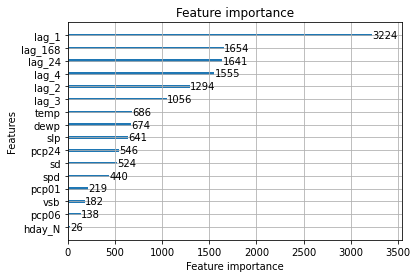

In [44]:
lgb.plot_importance(model)

In [92]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [93]:
y_test_df

pickup_dt
2015-05-09 19:00:00    4497
2015-05-09 20:00:00    4502
2015-05-09 21:00:00    3914
2015-05-09 22:00:00    3802
2015-05-09 23:00:00    4511
                       ... 
2015-06-30 19:00:00    4585
2015-06-30 20:00:00    4210
2015-06-30 21:00:00    4313
2015-06-30 22:00:00    4452
2015-06-30 23:00:00    3828
Name: pickups, Length: 1253, dtype: int64

In [95]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='2553', ...)